In [1]:
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from functools import partial

In [2]:
# Import data, custom figure-making functions
sys.path.append('/mnt/d/orchards')
from figure_constants import *
from figure_functions import *
sys.path.append(installDir+'scripts')
from chartannotator import add_stat_annotation
# print(adjustedTransmissionSNPs.SNP_frequency_index.max())
# x = transmissionSNPs.groupby(['index','contact','chrom','pos']).first().reset_index()
# x.loc[x.SNP_frequency_index > (1-SNP_frequency_cutoff),'SNP_frequency_index'] = 1
# x.loc[x.SNP_frequency_contact > (1-SNP_frequency_cutoff),'SNP_frequency_contact'] = 1
# x.loc[x.SNP_frequency_contact < SNP_frequency_cutoff,'SNP_frequency_contact'] = 0
# x.loc[x.SNP_frequency_index < SNP_frequency_cutoff,'SNP_frequency_index'] = 0
# x = x.loc[~((x.SNP_frequency_index == 1) & (x.SNP_frequency_contact == 1))]
# x = x.loc[~((x.SNP_frequency_index == 0) & (x.SNP_frequency_contact == 0))]
# x = x.loc[((x.SNP_frequency_index >.05) | (x.SNP_frequency_contact > .05))]


loading subjects...
loading samples...
loading segments...
loading genes...
loading SNPs...
loading transmission pairs...
loading transmission segments...
loading transmission SNPs...


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (58) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
#mcCrone chart setup
# adjustedTransmissionSNPs = adjustedTransmissionSNPs.replace('H1N1pdm','H1N1')
transmissionSNPs = transmissionSNPs.replace('H1N1pdm','H1N1')
subtypecolors = {'H3N2':palettes['subtype'][0],'H1N1':palettes['subtype'][1],'Influenza B':palettes['subtype'][2]}
mcCrone = transmissionSNPs.groupby(['index','contact','chrom','pos']).first().reset_index()
mcCrone = mcCrone.loc[mcCrone.kind=='transmission',['SNP_frequency_index','SNP_frequency_contact','segment','kind','AAtype','subtype']]
mcCrone.loc[mcCrone.SNP_frequency_index > (1-SNP_frequency_cutoff),'SNP_frequency_index'] = 1
mcCrone.loc[mcCrone.SNP_frequency_contact > (1-SNP_frequency_cutoff),'SNP_frequency_contact'] = 1
mcCrone.loc[mcCrone.SNP_frequency_contact < SNP_frequency_cutoff,'SNP_frequency_contact'] = 0
mcCrone.loc[mcCrone.SNP_frequency_index < SNP_frequency_cutoff,'SNP_frequency_index'] = 0
mcCrone = mcCrone.loc[~((mcCrone.SNP_frequency_index == 1) & (mcCrone.SNP_frequency_contact == 1))]
mcCrone = mcCrone.loc[~((mcCrone.SNP_frequency_index == 0) & (mcCrone.SNP_frequency_contact == 0))]
mcCrone = mcCrone.loc[~(mcCrone.AAtype == 'Out of reading frame')]

print(transmissionSNPs.SNP_frequency_index.max())
print(transmissionSNPs.SNP_frequency_index.max())


1.0
1.0


In [4]:
sns.set_theme(context='paper', style='white', font_scale=3)
pi = '\u03C0'
rcParams['font.sans-serif'] = 'Myriad Pro'


ax_letter_args = {'pad':30}
x_labelpad = 12
y_labelpad = 12

In [5]:
font_annotation_size = rcParams['font.size'] * .66
sigBar = partial(add_stat_annotation, **{'fontsize':font_annotation_size})

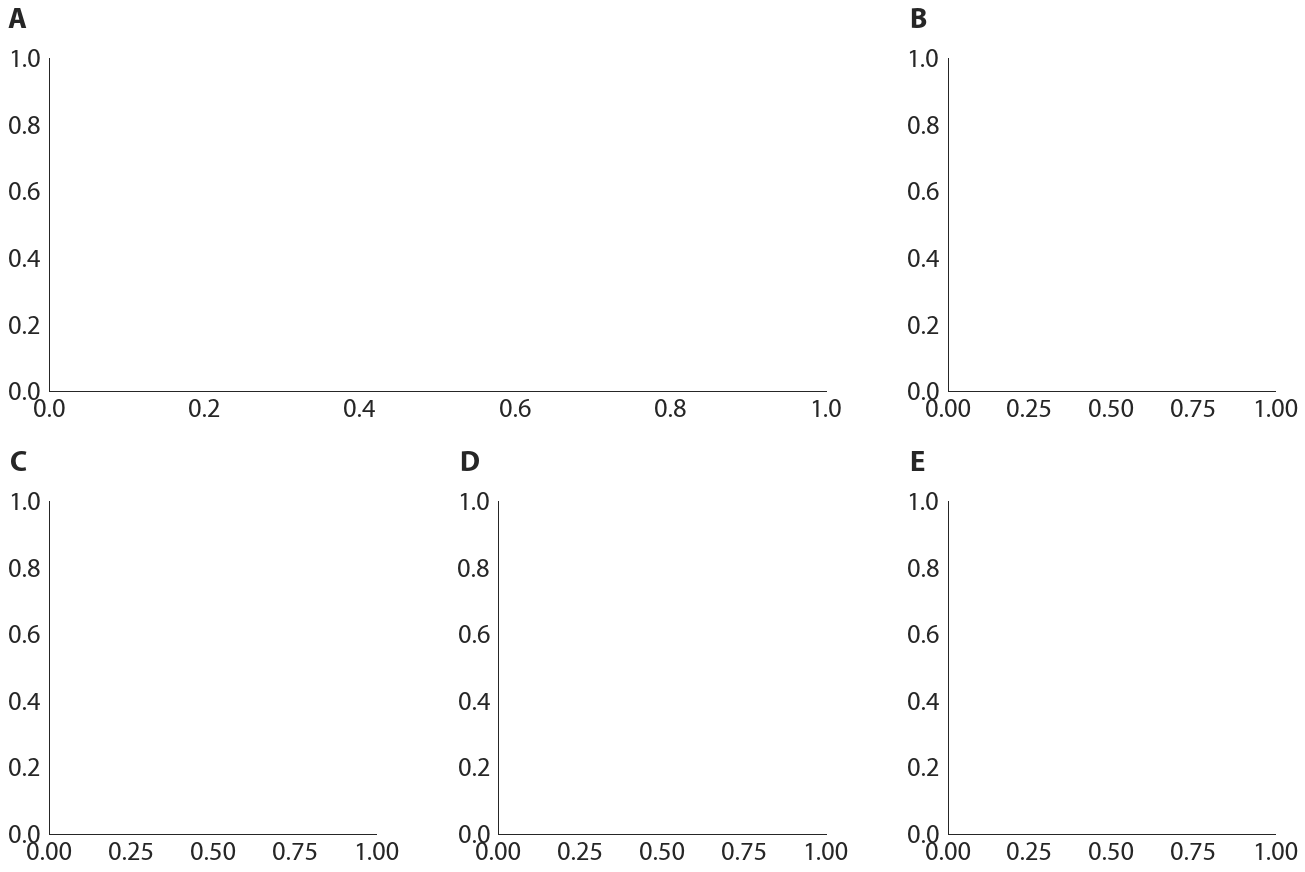

In [6]:
fig4 = plt.figure(figsize = (18, 12), constrained_layout=True) #24, 16
fig4.set_constrained_layout_pads(hspace=0.05, wspace=0.12)
gs = GridSpec(2,3,fig4)

ax4a = fig4.add_subplot(gs[0, 0:2])
ax4b = fig4.add_subplot(gs[0, 2:])
ax4c = fig4.add_subplot(gs[1, 0])
ax4d = fig4.add_subplot(gs[1, 1])
ax4e = fig4.add_subplot(gs[1, 2])
plt.rcParams['axes.titleweight'] = 'bold'
sns.despine(fig4)

figure_letter_x_offset = -35

def calc_figure_letter_offset(ax):
    return figure_letter_x_offset/ax.get_window_extent().width

ax4a.set_title('A', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax4a))
ax4b.set_title('B', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax4b))
ax4c.set_title('C', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax4c))
ax4d.set_title('D', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax4d))
ax4e.set_title('E', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax4e))

In [7]:
n = len(allvsall.loc[allvsall.household_match == 'Yes'])
allvsall = allvsall.loc[allvsall.ptID_index != allvsall.ptID_contact]
bootstrap_size = 10000
bootstrapped_results = list()



def bootstrap(df, n, y, stat):
    data = df.sample(n, replace=True)[y]
    if stat=='mean':
        return data.mean()
    if stat=='median':
        return data.median()
    elif stat=='ci':
        return data.sem()*1.96
    elif stat=='log_mean':
        return np.exp(np.mean(np.log(data.values)))
    elif stat=='log_ci':
        data = np.log(data)
        mean = data.mean()
        ci = data.sem()*1.96
        return np.exp(mean-ci), np.exp(mean+ci)
    elif stat=='mle':
        m = np.mean(np.log(data))
        s = np.mean((np.log(data)-m)**2)
        return np.exp(m+s/2)
    
def boostrap_mean_and_ci(data, var, label, bootstrap_size=1000):
    mean = data[var].mean()
    bootstraps = np.array([bootstrap(data, n, var,'mean') for _ in range(bootstrap_size)])
    ci = np.percentile(mean-bootstraps, (5, 95))
    return {var: mean, 'ci_low': -ci[0], 'ci_high':ci[1], 'Pairing': label, 'data':bootstraps}

bootstrapped_results.append(boostrap_mean_and_ci(allvsall, 'distance','Random', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], 'distance','Same Clade', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.school_match == 'Within school'], 'distance','Same School', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], 'distance','Same Subclade', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.household_match == 'Yes'], 'distance','Same Household', bootstrap_size))
bootstrapped_results = pd.DataFrame(bootstrapped_results)

r_c_pvalue = np.mean(bootstrapped_results['data'][0] < bootstrapped_results['data'][1])
c_s_pvalue = np.mean(bootstrapped_results['data'][1] < bootstrapped_results['data'][2])
s_s_pvalue = np.mean(bootstrapped_results['data'][2] < bootstrapped_results['data'][3])
s_h_pvalue = np.mean(bootstrapped_results['data'][3] < bootstrapped_results['data'][4])
pvalues = [r_c_pvalue, c_s_pvalue, s_s_pvalue, s_h_pvalue]
# def errorbar(ax, x, y, error, nonsymmetrical=False, order=None, color='black', log_normal=False):
#     xnum = [order.index(x_i) for x_i in x]
#     error = list(error)
#     if nonsymmetrical:
#         error[0] = np.array(error[0])
#         print(error[0])
#         error[1] = np.array(error[1])
#         error[0] = np.where((np.array(y)-error[0])<0, np.array(y), error[0])
#         print(error[0])
#         low = error[0]
#         high = error[1]
#     else:
#         low = error
#         high = error
        
#     if log_normal:
#         for i, (x, y, lowerr, higherr) in enumerate(zip(x, y, low, high)):
#             low[i] = y-(y/lowerr)
#             high[i] = (y*higherr)-y
#     print(list(zip(low, high)))
#     return ax.errorbar(xnum, y, yerr=(low, high), fmt="none", color=color, elinewidth=1, capsize=5)

# # fig, ax = plt.subplots(figsize=(20,2))
# # pairing_category_order = ['Random','Same Clade','Same School','Same Subclade','Same Household']
# # ax = sns.barplot(y='distance', x='Pairing', data=bootstrapped_results, ax=ax)

# # comparisons = [(pairing_category_order[i], pairing_category_order[i+1]) for i in range(len(pairing_category_order)-1)]
# # pvalues = [.04,.02,.01,.03]
# # ax, stats = sigBar(perform_stat_test=False, test=None,pvalues=pvalues,box_pairs=comparisons, ax=ax, use_fixed_offset_from_top=True, order=pairing_category_order, data=bootstrapped_results, x='Pairing',y='distance')
# # ax = errorbar(ax,
# #          bootstrapped_results['Pairing'].tolist(), 
# #          bootstrapped_results['distance'].tolist(), 
# #          (bootstrapped_results['ci_low'].tolist(), bootstrapped_results['ci_high'].tolist()), 
# #          nonsymmetrical=True,
# #          order = pairing_category_order)


Random: 42.88171313907531, Same Clade: 22.29940533120164
Random is greater than Same Clade: Custom statistical test, P_val:0.00e+00
(means: Random is greater than Same Clade: 42.88171313907531 vs 22.29940533120164)
Same Clade: 22.29940533120164, Same School: 18.338375621845938
Same Clade is greater than Same School: Custom statistical test, P_val:0.16
(means: Same Clade is greater than Same School: 22.29940533120164 vs 18.338375621845938)
Same School: 18.338375621845938, Same Subclade: 10.580352162553401
Same School is greater than Same Subclade: Custom statistical test, P_val:0.0058
(means: Same School is greater than Same Subclade: 18.338375621845938 vs 10.580352162553401)
Same Subclade: 10.580352162553401, Same Household: 4.633189496736475
Same Subclade is greater than Same Household: Custom statistical test, P_val:0.00e+00
(means: Same Subclade is greater than Same Household: 10.580352162553401 vs 4.633189496736475)
[8.34828216 4.39844891 5.42676514 2.23868969 0.78572358]
[8.348282

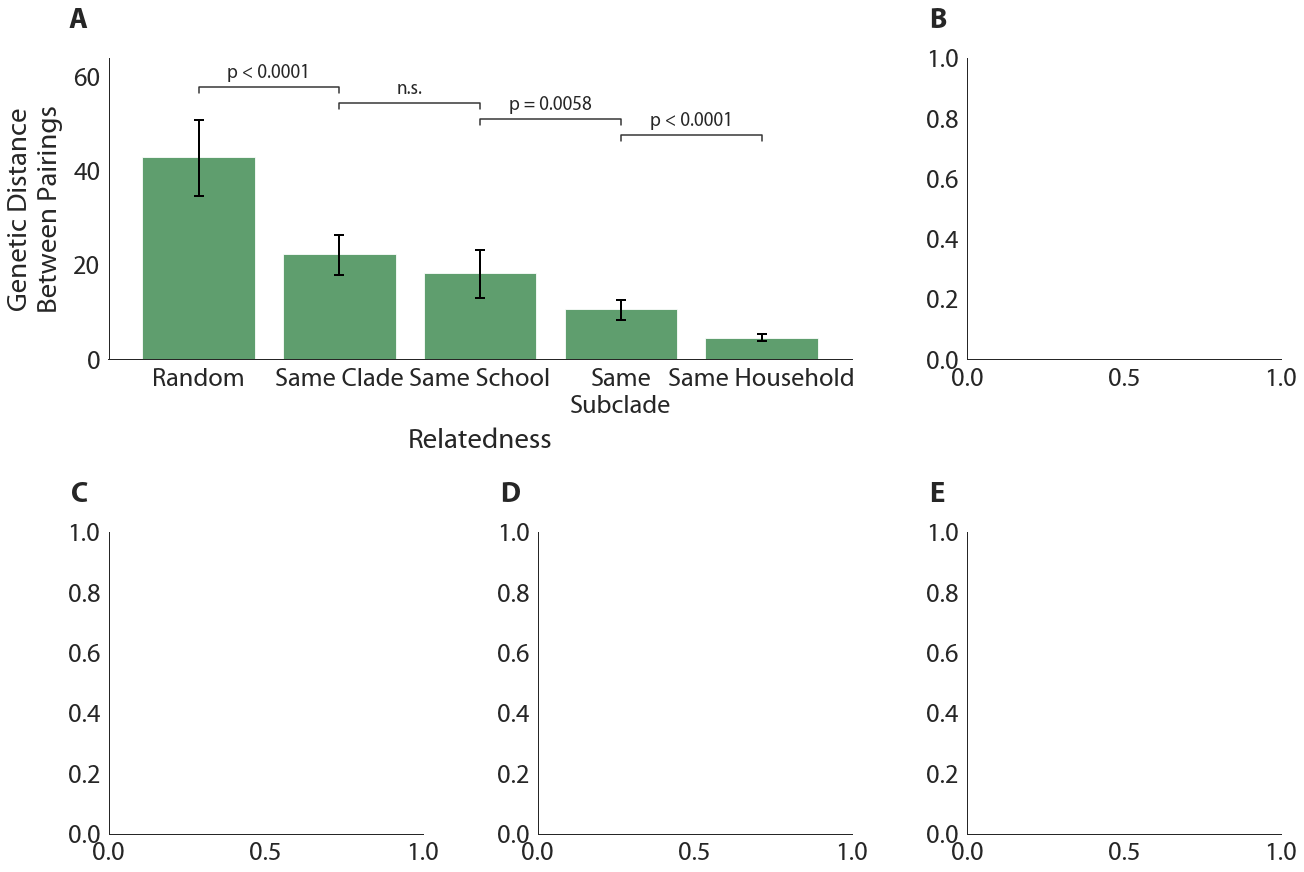

<Figure size 432x288 with 0 Axes>

In [8]:
#4a: relative distance of different categories of pairings
# fig, ax4a = plt.subplots(figsize=(24,6))
# ax4a.clear()
def defined_errorbar(ax, x, y, error, nonsymmetrical=False, order=None, color='black', log_normal=False):
    xnum = [order.index(x_i) for x_i in x]
    error = list(error)
    if nonsymmetrical:
        error[0] = np.array(error[0])
        print(error[0])
        error[1] = np.array(error[1])
        error[0] = np.where((np.array(y)-error[0])<0, np.array(y), error[0])
        print(error[0])
        low = error[0]
        high = error[1]
    else:
        low = error
        high = error
        
    if log_normal:
        for i, (x, y, lowerr, higherr) in enumerate(zip(x, y, low, high)):
            low[i] = y-(y/lowerr)
            high[i] = (y*higherr)-y
    print(list(zip(low, high)))
    ax.errorbar(xnum, y, yerr=(low, high), fmt="none", color=color, elinewidth=2, capsize=5, capthick=2)
    return ax

fig_args = {'x': 'Relatedness',
            'y': 'distance',
            'data': allvsall,
            'order':['Random','Same Clade','Same School','Same Subclade','Same Household'],
            'hue_order':['Unvaccinated', 'Vaccinated'],
            'color':subtypecolors['Influenza B'],#(19/255, 149/255, 116/255),
            'ax': ax4a}

pairing_category_order = ['Random','Same Clade','Same School','Same Subclade','Same Household']

comparisons = [(pairing_category_order[i], pairing_category_order[i+1]) for i in range(len(pairing_category_order)-1)]
ax4a = sns.barplot(y='distance', x='Pairing', data=bootstrapped_results, ax=ax4a, color=subtypecolors['Influenza B'])
def get_pvalue_text(pvalue):
    if pvalue == 0:
        return f'p < {1/bootstrap_size}'
    elif pvalue > 0.05:
        return 'n.s.'
    else:
        return f'p = {pvalue}'
pvalue_text = [get_pvalue_text(pvalue) for pvalue in pvalues]
ax4a, stats = sigBar(perform_stat_test=False, line_offset=-.175, test=None,pvalues=pvalues,text_annot_custom=pvalue_text, box_pairs=comparisons, ax=ax4a, line_offset_to_box=.3,order=pairing_category_order, data=bootstrapped_results, x='Pairing',y='distance')

ax4a.set_ylabel('Genetic Distance\nBetween Pairings', labelpad=10)
ax4a.set_xlabel('Relatedness', labelpad=10)
ax4a.set_xticklabels(['Random','Same Clade','Same School','Same\nSubclade','Same Household'])
ax4a = defined_errorbar(ax4a,
         bootstrapped_results['Pairing'].tolist(), 
         bootstrapped_results['distance'].tolist(), 
         (bootstrapped_results['ci_low'].tolist(), bootstrapped_results['ci_high'].tolist()), 
         nonsymmetrical=True,
         order = pairing_category_order)

fig4

In [9]:
# ax4a = sns.barplot(y='distance', x='Pairing', data=bootstrapped_results, yerr=[10,4,2,8,1], ax=ax4a)

# for x in ax4a.get_children():
#     print(x)
#     box = ax4a.transData.inverted().transform(x.get_window_extent(fig4.canvas.get_renderer()))
#     print(box)
#     print(x.properties()['clip_box'])
#     print(x.properties())
#     print ('\n')

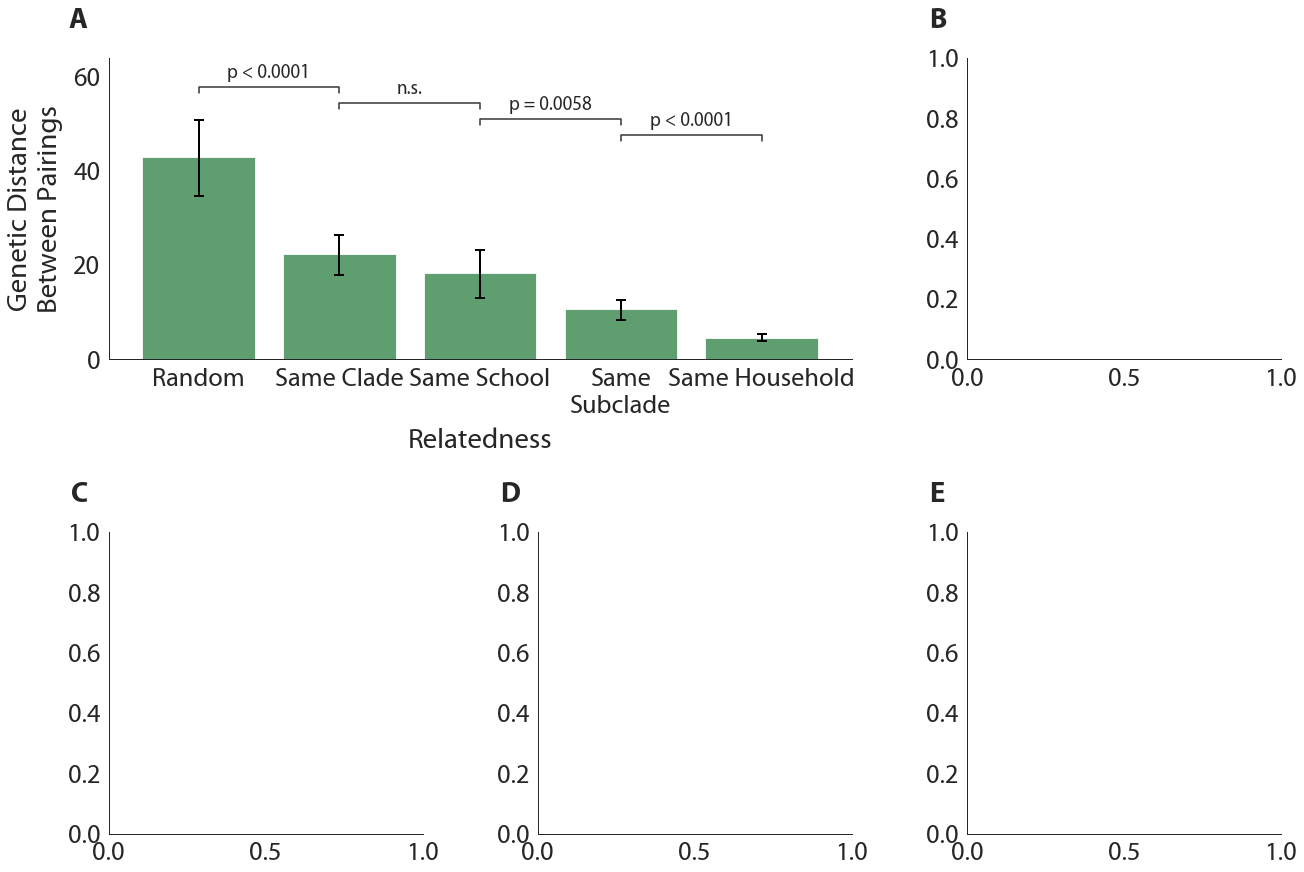

In [10]:
# 
# # print(bootstrapped_results)
# # ax4a.set_ylim(0,90)
fig4
# # plt.figure()
# # # ax = plt.gca()
# # ax= sns.barplot(data=bootstrapped_results, x='Pairing',y='distance')
# # bootstrapped_results
# # errorBarArgs

In [11]:
yerr=[10,4,2,8,1]
pd.DataFrame(bootstrapped_results)['distance'] += np.array(yerr)
# 
bootstrapped_results

,distance,ci_low,ci_high,Pairing,data
0,52.881713,8.348282,7.858451,Random,"[42.94521660881359, 41.31664754806352, 49.5234..."
1,26.299405,4.398449,4.009448,Same Clade,"[21.381184097737382, 24.208545335879638, 29.81..."
2,20.338376,5.426765,4.853512,Same School,"[18.771638978687456, 21.730597269623964, 17.07..."
3,18.580352,2.238690,1.915724,Same Subclade,"[9.323964275752711, 11.622022055891836, 10.651..."
4,5.633189,0.785724,0.740325,Same Household,"[5.087803278547038, 5.202317291915445, 4.45198..."


In [12]:
#4b: Bottleneck model shows narrow bottleneck
calcBottlenecks = False
if calcBottlenecks:
    subtypeBottlenecks = pd.DataFrame(koelleBottleneckCategorical(transmissionPairs.loc[transmissionPairs.kind=='transmission'], 'subtype'))
else:
    subtypeBottlenecks = pd.read_csv(dataFolder+'/subtypeBottlenecks.tsv', **read_tsv_args)

# fig, ax4b = plt.subplots()
fig_args = {'x':'Pairing Category',
            'y': 'Avg Bottleneck',
            'order': subtypeOrder,
            'data': subtypeBottlenecks,
            'ax':ax4b}

bottleneckchart = sns.stripplot(**fig_args, jitter=False, s=15)
bottleneckchart.margins(x=.33)

# order = sns.utils.categorical_order(subtypeBottlenecks['Pairing Category'])
bottleneckchart.set_xlabel('Subtype Transmitted', labelpad=10)
bottleneckchart.set_ylabel('Bottleneck Size', labelpad=10)

errorbar(subtypeBottlenecks["Avg Bottleneck"].tolist(), subtypeBottlenecks["Pairing Category"].tolist(), subtypeBottlenecks["Lower CI"].tolist(), subtypeBottlenecks["Upper CI"].tolist(), ax=ax4b, order=subtypeOrder, color="black")

<ErrorbarContainer object of 3 artists>

In [13]:
#4c: McCrone Chart H3N2


for subtype, ax in zip(['H3N2','H1N1','Influenza B'], [ax4c, ax4d, ax4e]):
    mcCrone_fig_args = {'x':'SNP_frequency_index',
                        'y': 'SNP_frequency_contact',
                        'data':mcCrone.loc[mcCrone.subtype==subtype],
                        'color': subtypecolors[subtype],
                        'linewidth':0,
                        'alpha': 0.2,
                        's':250,
                        'ax':ax
                        }
    sns.scatterplot(**mcCrone_fig_args)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

ax4c.set_ylabel('iSNV frequency in contact', labelpad=10)
ax4d.set_xlabel('iSNV frequency in index', labelpad=10)

Text(0.5, 3.1999999999999993, 'iSNV frequency in index')

In [14]:
fig4.savefig('/mnt/d/orchards/fig4.svg', format='svg')

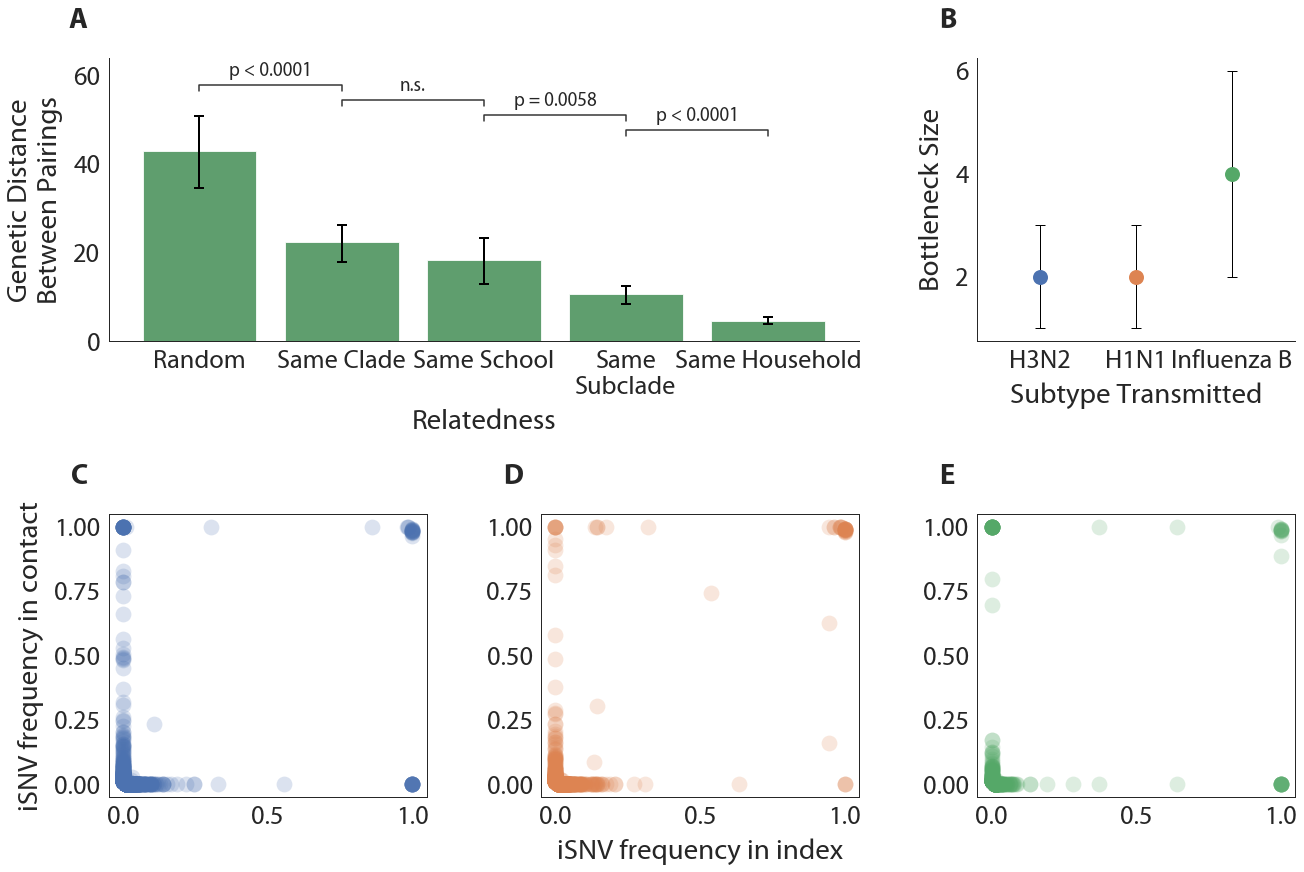

In [15]:
fig4

In [16]:
# #4a: relative distance of different categories of pairings
# # fig, ax4a = plt.subplots(figsize=(24,6))

# fig_args = {'x': 'Relatedness',
#             'y': 'distance',
#             'data': allvsall,
#             'order':['Random','Same Clade','Same School','Same Subclade','Same Household'],
#             'hue_order':['Unvaccinated', 'Vaccinated'],
#             'color':subtypecolors['Influenza B'],#(19/255, 149/255, 116/255),
#             'ax': ax4a}

# ax4a = sns.barplot(**fig_args, **errorBarArgs)

# ax4a.set_ylabel('Genetic Distance\nBetween Pairings', labelpad=10)
# ax4a.set_xlabel('Relatedness', labelpad=10)
# ax4a.set_xticklabels(['Random','Same Clade','Same School','Same\nSubclade','Same Household'])

In [17]:
def bootstrap(df, n, y, stat):
    data = df.sample(n, replace=True)[y]
    if stat=='mean':
        return data.mean()
    if stat=='median':
        return data.median()
    elif stat=='ci':
        return data.sem()*1.96
    elif stat=='log_mean':
        return np.exp(np.mean(np.log(data.values)))
    elif stat=='log_ci':
        data = np.log(data)
        mean = data.mean()
        ci = data.sem()*1.96
        return np.exp(mean-ci), np.exp(mean+ci)
    elif stat=='mle':
        m = np.mean(np.log(data))
        s = np.mean((np.log(data)-m)**2)
        return np.exp(m+s/2)
    
# allvsall = allvsall.loc[(pd.to_datetime(allvsall['time_of_symptom_onset_contact']) - pd.to_datetime(allvsall['time_of_symptom_onset_index'])) > pd.Timedelta(0)]
# allvsall = allvsall.loc[(pd.to_datetime(allvsall['time_of_symptom_onset_contact']) - pd.to_datetime(allvsall['time_of_symptom_onset_index'])) < pd.Timedelta('7 days')]

In [18]:
n = len(allvsall.loc[allvsall.household_match == 'Yes'])
allvsall = allvsall.loc[allvsall.ptID_index != allvsall.ptID_contact]
bootstrap_size = 1000
bootstrapped_results = list()

random_bootstraps_means = [bootstrap(allvsall, n, 'distance','log_mean') for _ in range(bootstrap_size)]
random_bootstraps_cis = [bootstrap(allvsall, n, 'distance','log_ci') for _ in range(bootstrap_size)]
random_bootstraps_cis = [np.mean([low for low, high in random_bootstraps_cis]), np.mean([high for low, high in random_bootstraps_cis])]
bootstrapped_results.append({'Distance': np.mean(random_bootstraps_means), 'ci_low': random_bootstraps_cis[0], 'ci_high': random_bootstraps_cis[1], 'Pairing': 'Random'})

clade_bootstraps_means = [bootstrap(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], n, 'distance','log_mean') for _ in range(bootstrap_size)]
clade_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], n, 'distance','log_ci') for _ in range(bootstrap_size)]
clade_bootstraps_cis = [np.mean([low for low, high in clade_bootstraps_cis]), np.mean([high for low, high in clade_bootstraps_cis])]
bootstrapped_results.append({'Distance': np.mean(clade_bootstraps_means), 'ci_low': clade_bootstraps_cis[0], 'ci_high': clade_bootstraps_cis[1], 'Pairing': 'Same Clade'})

school_bootstraps_means = [bootstrap(allvsall.loc[allvsall.school_match == 'Within school'], n, 'distance','log_mean') for _ in range(bootstrap_size)]
school_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.school_match == 'Within school'], n, 'distance','log_ci') for _ in range(bootstrap_size)]
school_bootstraps_cis = [np.mean([low for low, high in school_bootstraps_cis]), np.mean([high for low, high in school_bootstraps_cis])]
bootstrapped_results.append({'Distance': np.mean(school_bootstraps_means), 'ci_low': school_bootstraps_cis[0], 'ci_high': school_bootstraps_cis[1], 'Pairing': 'Same School'})

subclade_bootstraps_means = [bootstrap(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], n, 'distance','log_mean') for _ in range(bootstrap_size)]
subclade_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], n, 'distance','log_ci') for _ in range(bootstrap_size)]
subclade_bootstraps_cis = [np.mean([low for low, high in subclade_bootstraps_cis]), np.mean([high for low, high in subclade_bootstraps_cis])]
bootstrapped_results.append({'Distance': np.mean(subclade_bootstraps_means), 'ci_low': subclade_bootstraps_cis[0], 'ci_high': subclade_bootstraps_cis[1], 'Pairing': 'Same Subclade'})

hh_bootstraps_means = [bootstrap(allvsall.loc[allvsall.household_match == 'Yes'], n, 'distance','log_mean') for _ in range(bootstrap_size)]
hh_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.household_match == 'No'], n, 'distance','log_ci') for _ in range(bootstrap_size)]
hh_bootstraps_cis = [np.mean([low for low, high in hh_bootstraps_cis]), np.mean([high for low, high in hh_bootstraps_cis])]
bootstrapped_results.append({'Distance': np.mean(hh_bootstraps_means), 'ci_low': hh_bootstraps_cis[0], 'ci_high': hh_bootstraps_cis[1], 'Pairing': 'Same Household'})

bootstrapped_results = pd.DataFrame(bootstrapped_results)

In [19]:
n = len(allvsall.loc[allvsall.household_match == 'Yes'])
allvsall = allvsall.loc[allvsall.ptID_index != allvsall.ptID_contact]
bootstrap_size = 1000
bootstrapped_results = list()

random_bootstraps_means = [bootstrap(allvsall, n, 'distance','mean') for _ in range(bootstrap_size)]
random_bootstraps_cis = [bootstrap(allvsall, n, 'distance','ci') for _ in range(bootstrap_size)]
bootstrapped_results.append({'Distance': np.mean(random_bootstraps_means), 'ci': np.mean(random_bootstraps_cis), 'Pairing': 'Random'})

clade_bootstraps_means = [bootstrap(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], n, 'distance','mean') for _ in range(bootstrap_size)]
clade_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], n, 'distance','ci') for _ in range(bootstrap_size)]
bootstrapped_results.append({'Distance': np.mean(clade_bootstraps_means), 'ci': np.mean(clade_bootstraps_cis), 'Pairing': 'Same Clade'})

school_bootstraps_means = [bootstrap(allvsall.loc[allvsall.school_match == 'Within school'], n, 'distance','mean') for _ in range(bootstrap_size)]
school_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.school_match == 'Within school'], n, 'distance','ci') for _ in range(bootstrap_size)]
bootstrapped_results.append({'Distance': np.mean(school_bootstraps_means), 'ci': np.mean(school_bootstraps_cis), 'Pairing': 'Same School'})

subclade_bootstraps_means = [bootstrap(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], n, 'distance','mean') for _ in range(bootstrap_size)]
subclade_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], n, 'distance','ci') for _ in range(bootstrap_size)]
bootstrapped_results.append({'Distance': np.mean(subclade_bootstraps_means), 'ci': np.mean(subclade_bootstraps_cis), 'Pairing': 'Same Subclade'})

hh_bootstraps_means = [bootstrap(allvsall.loc[allvsall.household_match == 'Yes'], n, 'distance','mean') for _ in range(bootstrap_size)]
hh_bootstraps_cis = [bootstrap(allvsall.loc[allvsall.household_match == 'No'], n, 'distance','ci') for _ in range(bootstrap_size)]
bootstrapped_results.append({'Distance': np.mean(hh_bootstraps_means), 'ci': np.mean(hh_bootstraps_cis), 'Pairing': 'Same Household'})

bootstrapped_results = pd.DataFrame(bootstrapped_results)

In [20]:
n = len(allvsall.loc[allvsall.household_match == 'Yes'])
allvsall = allvsall.loc[allvsall.ptID_index != allvsall.ptID_contact]
bootstrap_size = 10000
bootstrapped_results = list()

def boostrap_mean_and_ci(data, var, label, bootstrap_size=1000):
    mean = data[var].mean()
    bootstraps = np.array([bootstrap(data, n, var,'mean') for _ in range(bootstrap_size)])
    ci = np.percentile(mean-bootstraps, (5, 95))
    return {var: mean, 'ci_low': -ci[0], 'ci_high':ci[1], 'Pairing': label, 'data':bootstraps}

bootstrapped_results.append(boostrap_mean_and_ci(allvsall, 'distance','Random', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], 'distance','Same Clade', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.school_match == 'Within school'], 'distance','Same School', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], 'distance','Same Subclade', bootstrap_size))
bootstrapped_results.append(boostrap_mean_and_ci(allvsall.loc[allvsall.household_match == 'Yes'], 'distance','Same Household', bootstrap_size))
bootstrapped_results = pd.DataFrame(bootstrapped_results)

r_c_pvalue = np.mean(bootstrapped_results['data'][0] < bootstrapped_results['data'][1])
c_s_pvalue = np.mean(bootstrapped_results['data'][1] < bootstrapped_results['data'][2])
s_s_pvalue = np.mean(bootstrapped_results['data'][2] < bootstrapped_results['data'][3])
s_h_pvalue = np.mean(bootstrapped_results['data'][3] < bootstrapped_results['data'][4])
pvalues = [r_c_pvalue, c_s_pvalue, s_s_pvalue, s_h_pvalue]
# clade_mean = allvsall.loc[allvsall.clade_index == allvsall.clade_contact, 'distance'].mean()
# clade_bootstraps_means = [bootstrap(allvsall.loc[allvsall.clade_index == allvsall.clade_contact], n, 'distance','mean') for _ in range(bootstrap_size)]
# clade_bootstraps_ci = np.percentile(clade_bootstraps_means, (5, 95))
# bootstrapped_results.append({'Distance': np.mean(clade_bootstraps_means), 'ci': np.mean(clade_bootstraps_cis), 'Pairing': 'Same Clade'})

# school_mean = allvsall.loc[allvsall.school_match == 'Within school']
# school_bootstraps_means = [bootstrap(allvsall.loc[allvsall.school_match == 'Within school'], n, 'distance','mean') for _ in range(bootstrap_size)]
# school_bootstraps_ci = [bootstrap(allvsall.loc[allvsall.school_match == 'Within school'], n, 'distance','ci') for _ in range(bootstrap_size)]
# bootstrapped_results.append({'Distance': np.mean(school_bootstraps_means), 'ci': np.mean(school_bootstraps_cis), 'Pairing': 'Same School'})

# subclade_bootstraps_means = [bootstrap(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], n, 'distance','mean') for _ in range(bootstrap_size)]
# subclade_bootstraps_ci = [bootstrap(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact], n, 'distance','ci') for _ in range(bootstrap_size)]
# bootstrapped_results.append({'Distance': np.mean(subclade_bootstraps_means), 'ci': np.mean(subclade_bootstraps_cis), 'Pairing': 'Same Subclade'})

# hh_bootstraps_means = [bootstrap(allvsall.loc[allvsall.household_match == 'Yes'], n, 'distance','mean') for _ in range(bootstrap_size)]
# hh_bootstraps_ci = [bootstrap(allvsall.loc[allvsall.household_match == 'No'], n, 'distance','ci') for _ in range(bootstrap_size)]
# bootstrapped_results.append({'Distance': np.mean(hh_bootstraps_means), 'ci': np.mean(hh_bootstraps_cis), 'Pairing': 'Same Household'})

bootstrapped_results
# x = np.array(hh_bootstraps_means) - allvsall.loc[allvsall.household_match == 'Yes', 'distance'].mean()

# x[50]

,distance,ci_low,ci_high,Pairing,data
0,42.881713,9.031518,8.451073,Random,"[46.82553556712345, 40.697363090948116, 44.300..."
1,22.299405,4.645559,4.310058,Same Clade,"[22.618982034177822, 24.9699609054146, 22.9301..."
2,18.338376,6.167127,5.242756,Same School,"[13.223867895469633, 24.867652130757065, 22.25..."
3,10.580352,2.353155,2.067054,Same Subclade,"[11.000991399144917, 9.923293407238782, 8.9890..."
4,4.633189,0.851580,0.810797,Same Household,"[5.315737278120307, 4.8763496367366095, 4.7106..."


TypeError: errorbar() got an unexpected keyword argument 'nonsymmetrical'

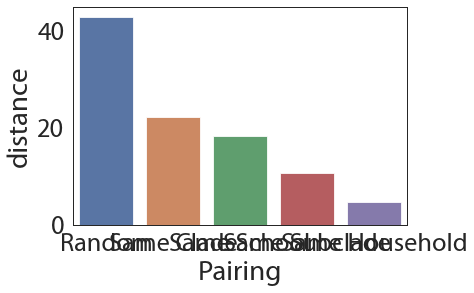

In [21]:

fig, ax = plt.subplots()
pairing_category_order = ['Random','Same Clade','Same School','Same Subclade','Same Household']
ax = sns.barplot(y='distance', x='Pairing', data=bootstrapped_results, ax=ax)
ax = errorbar(ax,
         bootstrapped_results['Pairing'].tolist(), 
         bootstrapped_results['distance'].tolist(), 
         (bootstrapped_results['ci_low'].tolist(), bootstrapped_results['ci_high'].tolist()), 
         nonsymmetrical=True,
         order = pairing_category_order)


In [ ]:

pvalues

In [ ]:
sns.distplot(np.array(hh_bootstraps_means))

In [ ]:
# from scipy import stats
# stats.ttest_ind(random_bootstraps_means,clade_bootstraps_means)
allvsall.loc[allvsall.ptID_index != allvsall.ptID_contact, ['ptID_index','ptID_contact']]
# pd.to_datetime(allvsall['time_of_symptom_onset_contact']) - pd.to_datetime(allvsall['time_of_symptom_onset_index'])

In [ ]:
len(allvsall.loc[allvsall.subclade_index == allvsall.subclade_contact])

In [ ]:
# plt.yscale('log')
selfpairs = transmissionPairs.loc[transmissionPairs.kind=='self']
hhpairs = transmissionPairs['index'] + transmissionPairs['contact']
sns.swarmplot(data=allvsall.loc[(allvsall['index'] + allvsall['contact']).isin(hhpairs)], y='distance')
d = transmissionPairs.loc[transmissionPairs.kind == 'transmission'].distance/2#allvsall.loc[(allvsall['index'] + allvsall['contact']).isin(hhpairs), 'distance']

ci = d.mean()+d.sem()*3.496
plt.gca().axhline(12.277214671088878)#d.mean()+d.sem()*3.496) #99.9th ci

# transmissionPairs.loc[transmissionPairs.distance/2 > np.percentile(transmissionPairs.distance/2, 50)]
# np.percentile(transmissionPairs.distance/2, 97.5)
r = boostrap_mean_and_ci(transmissionPairs.loc[transmissionPairs.kind == 'transmission'], 'distance','Same Household', bootstrap_size)

In [ ]:
a = r['data']
a.sort()
a[9500]
ci

In [ ]:
transmissionSNPs.loc[(transmissionSNPs['product']=='HA_antigenic') & (transmissionSNPs.abs_SNP_frequency_difference > 0.1), 'distance']

In [ ]:
candidatecases = subjects.loc[subjects.household == 1825.0]
candidatecases[['day0_sample','day7_sample', 'isIndexCase']]
candidatecases.time_of_symptom_onset = pd.to_datetime(candidatecases.time_of_symptom_onset)
first_onset = pd.to_datetime(candidatecases.time_of_symptom_onset.dropna().dt.date.min(skipna=True))
potentialindexcases = candidatecases.loc[abs(candidatecases.time_of_symptom_onset - first_onset - pd.to_timedelta('12 hours')) < pd.to_timedelta('24 hours')]

indexcase = candidatecases.loc[pd.to_datetime(candidatecases.time_of_symptom_onset.dt.date) == first_onset, 'participant_ID']
indexcase = indexcase.values[0]



In [ ]:
t = distanceDF.stack()
t = t.reset_index().dropna()
t = t.rename(columns={'Unnamed: 0':'index','level_1':'contact',0:'distance'}).dropna()
t
t = t.merge(samples, left_on='index',right_on='sampleID',how='left')
t = t.merge(samples, left_on='contact',right_on='sampleID',how='left', suffixes=('_index','_contact'))
t

In [ ]:
# t = t.loc[(pd.to_datetime(t['time_of_symptom_onset_contact']) - pd.to_datetime(allvsall['time_of_symptom_onset_index'])) > pd.Timedelta(0)]
t = t.loc[np.abs(pd.to_datetime(t['time_of_symptom_onset_contact']) - pd.to_datetime(t['time_of_symptom_onset_index'])) < pd.Timedelta('7 days')]

t = t.loc[t.subtype_index == t.subtype_contact]


In [ ]:
t[['contact', 'index']]
# t[['index', 'contact']]


In [ ]:
fig4